In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from joblib import Parallel, delayed

In [3]:
import pickle

# Data

##### Immune_ALL_hum_mou.h5ad file is available at https://figshare.com/articles/dataset/Benchmarking_atlas-level_data_integration_in_single-cell_genomics_-_integration_task_datasets_Immune_and_pancreas_/12420968

In [5]:
hm = anndata.read_h5ad('data/Immune_ALL_hum_mou.h5ad')

In [6]:
hm.layers['norm_data'] = (hm.layers['counts'].T/hm.layers['counts'].sum(1)).T*np.median(hm.layers['counts'].sum(1))
hm.layers['log1p'] = np.log1p(hm.layers['norm_data'])
hm.layers['norm'] = hm.layers['norm_data']

In [8]:
dat_dir = 'results/'
fig_dir = 'figures/'


# Visualize and prepare data

In [9]:
# process
hm.X = hm.layers['log1p']
sc.pp.pca(hm, 50)
sc.pp.neighbors(hm, n_pcs = 50)
sc.tl.umap(hm)

In [10]:
# sc.pl.umap(hm, color = ['species', 'final_annotation'])

In [11]:
# sc.pl.umap(hm, color = ['tissue', 'batch'])

In [13]:
hm.obs['treatment'] = hm.obs['species']

In [14]:
# subset to highly variable
sc.pp.highly_variable_genes(hm, n_top_genes = 2000)
hvg = hm.var.index[hm.var['highly_variable']]
hm_sub = hm[:, hvg].copy()

In [20]:
cur = hm_sub.copy()

In [21]:
cur.obs['celltype'] = cur.obs['final_annotation']

In [22]:
cur.obs['sample'] = cur.obs['batch']

In [23]:
cur.layers['raw'] = cur.layers['counts']

In [24]:
# define experimental design
bt_design = cur.obs[['sample', 'batch', 'treatment']]
bt_design = bt_design.drop_duplicates().reset_index(drop = True)

bt_design.set_index('sample', inplace = True)
samples =  bt_design.index.values

# Apply LIGER

In [25]:
# def scale_by_group(cur, grp= 'sample'):
#     a = pd.DataFrame(cur.layers['norm'].copy(), index = cur.obs[grp])
#     gene_norms = a.groupby(grp).apply(lambda x: np.linalg.norm(x,axis = 0))
#     shapes = {}
#     for s in np.unique(a.index):
#         shapes[s] = np.sqrt(a.loc[s].shape[0]-1)
#     a = a.divide(np.array([gene_norms.loc[s]/shapes[s] for s in a.index]),1).values
#     cur.layers['scaled_by_'+grp] = a
#     cur.layers['scaled_by_'+grp] = pd.DataFrame(a).fillna(0).values

In [26]:
# scale_by_group(cur, grp= 'sample')

In [27]:
# scale genes within each sample
a = pd.DataFrame(cur.layers['norm'].copy(), index = cur.obs['sample'])
gene_norms = a.groupby('sample').apply(lambda x: np.linalg.norm(x,axis = 0))
shapes = {}
for s in np.unique(a.index):
    shapes[s] = np.sqrt(a.loc[s].shape[0]-1)
a = a.divide(np.array([gene_norms.loc[s]/shapes[s] for s in a.index]),1).values
cur.layers['scaled_by_sample'] = a
cur.layers['scaled_by_sample'] = pd.DataFrame(a).fillna(0).values

In [28]:
# remove batches that are too small
min_cells_in_batch = 1000
batch_counts = cur.obs['batch'].value_counts()
batches_to_remove = batch_counts[batch_counts<min_cells_in_batch].index

In [29]:
cur = cur[~cur.obs['batch'].isin(batches_to_remove),:]

In [30]:
cur.shape

(96348, 2000)

In [31]:
cur.obs['batch_full'] = cur.obs['batch'].copy()
cur.obs['batch']  = pd.factorize(cur.obs['batch'].values)[0]
cur.obs['treatment_full'] = cur.obs['treatment'].copy()
cur.obs['treatment']  = pd.factorize(cur.obs['treatment'].values)[0]

In [32]:
bt_design = cur.obs[['sample', 'batch', 'treatment']]
bt_design = bt_design.drop_duplicates().reset_index(drop = True)

bt_design.set_index('sample', inplace = True)
samples =  bt_design.index.values

In [33]:
bt_design.shape

(19, 2)

# LIGER

In [ ]:
import sys
sys.path.append('../../')

from DAISEE import *
from DAISEE_utils import *

In [34]:
num_factors = 30
max_iters = 30

In [35]:
ind = np.concatenate([np.where(cur.obs['treatment'] == i)[0] for i in np.unique(bt_design['treatment'])])
adat_copy = cur[ind,:].copy()
l_test = [2**p for p in range(-3, 7)]
num_batches = len(np.unique(adat_copy.obs['batch']))
min_cells = int(10000/num_batches)

In [36]:
adat_copy.shape

(96348, 2000)

In [31]:
# setup liger
adata_list = setup_data_condition(dat = cur, 
                                  bt_design = bt_design)
liger_obj = setup_liger_condition(adata_list = adata_list, 
                                   dat = cur, 
                                   bt_design = bt_design,
                                   remove_missing = False)


(33506, 2000)
(62842, 2000)


In [39]:
k_agree = 100

In [ ]:
#benchmark agreement and alignment for LIGER
liger_ag = {}
liger_al = {}
rand_seed = 1
for rep in range(10):
    adata_list = setup_data_condition(dat = cur, 
                                  bt_design = bt_design)
    liger_obj = setup_liger_condition(adata_list = adata_list, 
                                       dat = cur, 
                                       bt_design = bt_design,
                                       remove_missing = False)
    pyliger.optimize_ALS(liger_obj, 
                     k = num_factors, 
                     value_lambda=5, 
                     nrep = 1, 
                     rand_seed = rand_seed+rep,
                     max_iters=max_iters)
    pyliger.quantile_norm(liger_obj, 
                      ref_dataset = 'Stim 0')
    #reorder data
    ind = list(np.concatenate([np.where(cur.obs['treatment'] == i)[0] for i in range(2)]))
    adat_copy = cur[ind,:]#.copy()
    H_norm = [liger_obj.adata_list[i].obsm['H_norm'] for i in range(2)]
    H_norm= pd.DataFrame(np.concatenate(H_norm,0))
    H_norm.columns = ['H_norm_'+str(i) for i in range(num_factors)]
    adat_copy.obs[H_norm.columns] = H_norm.values
    H_norm.index = adat_copy.obs.index
    agree = calcAgreement(liger_obj,
                      H_norm, 
                      adat_copy, 
                      samples,
                      ndims=num_factors, 
                      k=k_agree, 
                      use_aligned=True, 
                      rand_seed=rand_seed+rep, 
                      n_jobs = 60, 
                      by_dataset=False)
    liger_ag[rep] = agree
    align = calcAlignment(liger_obj, 
                      H_norm,
                      adat_copy.obs['batch'], 
                      min_cells = min_cells,
                      rand_seed=rand_seed+rep, 
                      n_jobs = 60,
                      by_cell = False)
    liger_al[rep] = align

In [47]:
# import pickle
# f = open(dat_dir+'liger_al.p', 'wb')
# pickle.dump(liger_al, f)
# f.close()

In [48]:
# import pickle
# f = open(dat_dir+'liger_ag.p', 'wb')
# pickle.dump(liger_ag, f)
# f.close()

In [76]:
# import pickle
# f = open(dat_dir+'liger_object.p', 'wb')
# pickle.dump(liger_obj, f)
# f.close()

In [40]:
import pickle
f = open(dat_dir+'liger_object.p', 'rb')
liger_obj = pickle.load(f)
f.close()

In [ ]:
pyliger.quantile_norm(liger_obj, 
                  ref_dataset = 'Stim 0')

In [41]:
ind = list(np.concatenate([np.where(cur.obs['treatment'] == i)[0] for i in range(2)]))
adat_copy = cur[ind,:].copy()
H_norm = [liger_obj.adata_list[i].obsm['H_norm'] for i in range(2)]
H_norm= pd.DataFrame(np.concatenate(H_norm,0))
H_norm.columns = ['H_norm_'+str(i) for i in range(num_factors)]
adat_copy.obs[H_norm.columns] = H_norm.values
H_norm.index = adat_copy.obs.index


In [55]:
align = calcAlignment(liger_obj, 
                      H_norm,
                      adat_copy.obs['batch'], 
                      min_cells = min_cells,
                      n_jobs = 60,
                      by_cell = False)
align

963
9994


0.9427658383422808

In [42]:
agree = calcAgreement(liger_obj,
                      H_norm, 
                      adat_copy, 
                      samples,
                      ndims=num_factors, 
                      k=k_agree, 
                      use_aligned=True, 
                      rand_seed=42,#rand_seed+rep, 
                      n_jobs = 60, 
                      by_dataset=False)

Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


In [43]:
agree

0.09577214525825051

In [49]:
# f = open(dat_dir+'Agreement_LIGER.p', 'wb')
# pickle.dump(agree,f)
# f.close()

In [50]:
# f = open(dat_dir+'Alignment_LIGER.p', 'wb')
# pickle.dump(align,f)
# f.close()

# DAISEE benchmark

## Vary lambda_B

In [1]:
#benchmark agreement and alignment for DAISEE

In [209]:
l_test = [2**p for p in range(-3, 7)]
align_test = Parallel(n_jobs=-1)(delayed(test_B_lambda)(l_test[i],
                                                        i+1, 
                                                        nrep = 10,
                                                        k = 30,
                                                        k_agree = 100,
                                                        max_iters = 30, 
                                                        min_cells = min_cells) for i in range(len(l_test)))


2024-03-20 14:38:33.883580: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-20 14:38:33.883600: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-20 14:38:33.883720: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-20 14:38:33.883736: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-20 14:38:33.883662: W tensorflow/com

Testing 16...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  3%|▎         | 1/30 [00:32<15:50, 32.79s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.125...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  7%|▋         | 2/30 [01:09<16:28, 35.31s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 32...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.5...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  3%|▎         | 1/30 [00:44<21:17, 44.06s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 2...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 10%|█         | 3/30 [01:45<16:03, 35.68s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 1...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  3%|▎         | 1/30 [00:33<16:18, 33.74s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 64...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 10%|█         | 3/30 [01:51<16:29, 36.65s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 8...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 4...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.25...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


100%|██████████| 30/30 [13:59<00:00, 27.97s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 16...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  7%|▋         | 2/30 [01:07<15:34, 33.39s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.125...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  3%|▎         | 1/30 [00:37<18:14, 37.76s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 32...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  7%|▋         | 2/30 [01:24<19:58, 42.82s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 2...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.5...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 1...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 10%|█         | 3/30 [02:01<18:05, 40.19s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 64...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  3%|▎         | 1/30 [00:38<18:49, 38.94s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 4...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  7%|▋         | 2/30 [01:12<16:43, 35.84s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 8...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 17%|█▋        | 5/30 [03:05<14:41, 35.27s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.25...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


100%|██████████| 30/30 [13:53<00:00, 27.78s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 16...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  3%|▎         | 1/30 [00:29<14:27, 29.91s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.125...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 13%|█▎        | 4/30 [02:13<14:38, 33.81s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 32...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 17%|█▋        | 5/30 [03:00<16:06, 38.65s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 64...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 1...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  3%|▎         | 1/30 [00:32<15:54, 32.91s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.5...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 2...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 4...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  7%|▋         | 2/30 [01:03<14:46, 31.66s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 8...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  3%|▎         | 1/30 [00:30<14:45, 30.53s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.25...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 97%|█████████▋| 29/30 [13:34<00:28, 28.39s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 16...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  3%|▎         | 1/30 [00:28<13:40, 28.28s/it]]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.125...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 10%|█         | 3/30 [01:52<17:18, 38.47s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 32...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 64...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 13%|█▎        | 4/30 [02:25<15:50, 36.57s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 1...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 17%|█▋        | 5/30 [02:59<14:43, 35.34s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 4...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  3%|▎         | 1/30 [00:32<15:49, 32.74s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.5...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 2...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 10%|█         | 3/30 [01:34<14:08, 31.44s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 8...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 33%|███▎      | 10/30 [05:11<10:10, 30.53s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.25...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 97%|█████████▋| 29/30 [12:50<00:26, 26.97s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 16...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  7%|▋         | 2/30 [00:58<13:40, 29.29s/it]]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.125...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 23%|██▎       | 7/30 [03:27<11:39, 30.43s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 1...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 13%|█▎        | 4/30 [02:08<14:21, 33.15s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 64...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 17%|█▋        | 5/30 [02:45<14:29, 34.79s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 32...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 30%|███       | 9/30 [04:47<12:28, 35.62s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 4...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  3%|▎         | 1/30 [00:35<16:57, 35.07s/it]]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 2...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 13%|█▎        | 4/30 [02:20<15:35, 35.97s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.5...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 8...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  7%|▋         | 2/30 [01:12<17:02, 36.53s/it]]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.25...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 93%|█████████▎| 28/30 [12:53<00:55, 27.72s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 16...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  7%|▋         | 2/30 [01:01<14:20, 30.72s/it]]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.125...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 10%|█         | 3/30 [01:29<13:32, 30.10s/it]]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 1...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 20%|██        | 6/30 [03:02<12:22, 30.93s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 64...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 32...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 10%|█         | 3/30 [01:52<17:06, 38.03s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 4...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 27%|██▋       | 8/30 [04:07<11:40, 31.84s/it]]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 2...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 17%|█▋        | 5/30 [03:00<14:46, 35.46s/it]]

Testing 8...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
 10%|█         | 3/30 [01:42<15:10, 33.73s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.5...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 10%|█         | 3/30 [01:44<15:24, 34.23s/it]]

Testing 0.25...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
 90%|█████████ | 27/30 [12:31<01:23, 27.92s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 16...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  7%|▋         | 2/30 [01:00<14:15, 30.55s/it]]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.125...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 17%|█▋        | 5/30 [02:26<12:05, 29.01s/it]]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 1...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 27%|██▋       | 8/30 [03:57<11:02, 30.10s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 64...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 20%|██        | 6/30 [03:10<12:58, 32.45s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 4...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 30%|███       | 9/30 [04:32<11:00, 31.44s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 32...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  3%|▎         | 1/30 [00:32<15:42, 32.50s/it]]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 2...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 13%|█▎        | 4/30 [02:20<15:04, 34.78s/it]]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 8...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  7%|▋         | 2/30 [01:17<18:10, 38.95s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.5...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 43%|████▎     | 13/30 [06:44<09:33, 33.72s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.25...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


100%|██████████| 30/30 [13:43<00:00, 27.47s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 16...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 97%|█████████▋| 29/30 [13:00<00:28, 28.11s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.125...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 13%|█▎        | 4/30 [01:57<12:38, 29.19s/it]]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 1...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 30%|███       | 9/30 [04:17<09:58, 28.50s/it]]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 64...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 4...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 33%|███▎      | 10/30 [04:48<09:45, 29.29s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 32...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  7%|▋         | 2/30 [01:16<18:30, 39.67s/it]]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 2...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  3%|▎         | 1/30 [00:40<19:48, 41.00s/it]]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 8...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 47%|████▋     | 14/30 [06:58<08:42, 32.64s/it]

Testing 0.5...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  7%|▋         | 2/30 [01:13<16:53, 36.20s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
 13%|█▎        | 4/30 [02:32<16:39, 38.43s/it]

Testing 0.25...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 97%|█████████▋| 29/30 [13:34<00:27, 27.74s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 16...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 93%|█████████▎| 28/30 [12:49<00:56, 28.11s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.125...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


100%|██████████| 30/30 [13:39<00:00, 27.33s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 1...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 30%|███       | 9/30 [04:26<10:19, 29.51s/it]]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 64...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 17%|█▋        | 5/30 [02:31<13:04, 31.40s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 32...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  3%|▎         | 1/30 [00:31<15:24, 31.87s/it]]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 4...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 10%|█         | 3/30 [01:42<15:13, 33.84s/it]]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 2...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 17%|█▋        | 5/30 [02:49<14:00, 33.63s/it]]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 8...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 40%|████      | 12/30 [05:53<09:15, 30.84s/it]
/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.5...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



/mnt/home/mavdeeva/.local/lib/python3.8/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.25...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


100%|██████████| 30/30 [14:07<00:00, 28.24s/it]

Testing 16...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


Testing 1...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


Testing 0.125...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


In [44]:
from scipy.sparse import csr_matrix
cur.layers['raw'] = csr_matrix(cur.layers['raw'])

In [ ]:
l_test = [2**p for p in range(-3, 7)]
align_test = Parallel(n_jobs=len(l_test)*3)(delayed(test_B_lambda)(l_test[i],
                                                                   i+1, 
                                                                   dat = cur,
                                                                   bt_design = bt_design, 
                                                                   nrep = 10,
                                                                   k = 30,
                                                                   k_agree = 100,
                                                                   max_iters = 30,
                                                                   min_cells = min_cells,
                                                                   calc_agreement = True
                                                                  ) for i in range(len(l_test)))


/mnt/home/mavdeeva/zebrafish/lib/python3.8/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  0%|          | 0/30 [00:00<?, ?it/s]

Testing 1...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



  0%|          | 0/30 [00:00<?, ?it/s]

Testing 4...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 8...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 64...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 16...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 2...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.125...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.5...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  3%|▎         | 1/30 [01:05<31:32, 65.28s/it]

Testing 32...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.25...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 1...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 4...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 64...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



  0%|          | 0/30 [00:00<?, ?it/s]

Testing 8...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 16...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



  0%|          | 0/30 [00:00<?, ?it/s]

Testing 2...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.25...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 32...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.125...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.5...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 4...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



  0%|          | 0/30 [00:00<?, ?it/s]

Testing 1...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 16...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 64...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 8...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.25...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



  0%|          | 0/30 [00:00<?, ?it/s]

Testing 2...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.5...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 32...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.125...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 1...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



  0%|          | 0/30 [00:00<?, ?it/s]

Testing 4...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  7%|▋         | 2/30 [01:51<26:12, 56.15s/it]

Testing 16...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



  0%|          | 0/30 [00:00<?, ?it/s]

Testing 64...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.25...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



  0%|          | 0/30 [00:00<?, ?it/s]

Testing 32...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.5...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.125...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 8...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 2...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 1...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



  0%|          | 0/30 [00:00<?, ?it/s]

Testing 4...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 16...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 64...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.25...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 32...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 8...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.125...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 2...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.5...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 16...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



  0%|          | 0/30 [00:00<?, ?it/s]

Testing 1...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 4...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 64...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.25...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 8...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 32...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


  0%|          | 0/30 [00:00<?, ?it/s]

Testing 0.5...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]


 13%|█▎        | 4/30 [04:06<26:54, 62.10s/it]

Testing 2...
963
9994
Reducing dimensionality using NMF
Transformed
[2586, 3265, 3730, 3347, 10727, 1725, 2281, 2403, 2420, 1022, 7839, 7448, 7542, 7576, 3273, 2699, 5286, 8164, 13015]



 13%|█▎        | 4/30 [03:55<24:58, 57.63s/it]

In [ ]:
f = open(dat_dir+'Alignment_per_lambda_k_30.p', 'wb')
pickle.dump(align_test,f)
f.close()

In [58]:
f = open(dat_dir+'Alignment_per_lambda_k_30.p', 'rb')
align_test = pickle.load(f)
f.close()

In [69]:
# f = open('../benchmarks/immune/Alignment_per_lambda_k_30.p', 'wb')
# pickle.dump(align_test, f)
# f.close()

In [ ]:
# f = open('../benchmarks/immune/Alignment_per_lambda_k_30.p', 'rb')
# align_test = pickle.load(f)
# f.close()

In [ ]:
agree_test = pd.DataFrame([x[1] for x in align_test])
align_test = pd.DataFrame([x[0] for x in align_test])
align_test.columns.names = ['Replicate']
align_test.index = np.log2(l_test)
align_test.index.names = ['log2($\lambda_b$)']
align_test = align_test.stack().reset_index()
align_test.columns = ['log2($\lambda_b$)', 'Replicate', 'Alignment']
agree_test.columns.names = ['Replicate']
agree_test.index = np.log2(l_test)
agree_test.index.names = ['log2($\lambda_b$)']
agree_test = agree_test.stack().reset_index()
agree_test.columns = ['log2($\lambda_b$)', 'Replicate', 'Agreement']
align_test['Agreement'] = agree_test['Agreement']

In [ ]:
%matplotlib inline

In [ ]:
f = open(dat_dir+'liger_al.p', 'rb')
liger_al = pickle.load(f)
f.close()

In [ ]:
f = open(dat_dir+'liger_ag.p', 'rb')
liger_ag = pickle.load(f)
f.close()

# Supplementary Figure 2B

In [ ]:
liger_al = pd.Series(liger_al)
liger_ag = pd.Series(liger_ag)

In [ ]:
liger_al = pd.DataFrame(np.tile(liger_al.reset_index(), (10,1)))
liger_al.columns = ['Replicate', 'Alignment']
liger_ag = pd.DataFrame(np.tile(liger_ag.reset_index(), (10,1)))
liger_ag.columns = ['Replicate', 'Agreement']
liger_metr = liger_al.copy()
liger_metr['Agreement'] = liger_ag['Agreement']
liger_metr['log2($\lambda_b$)'] = align_test['log2($\lambda_b$)']

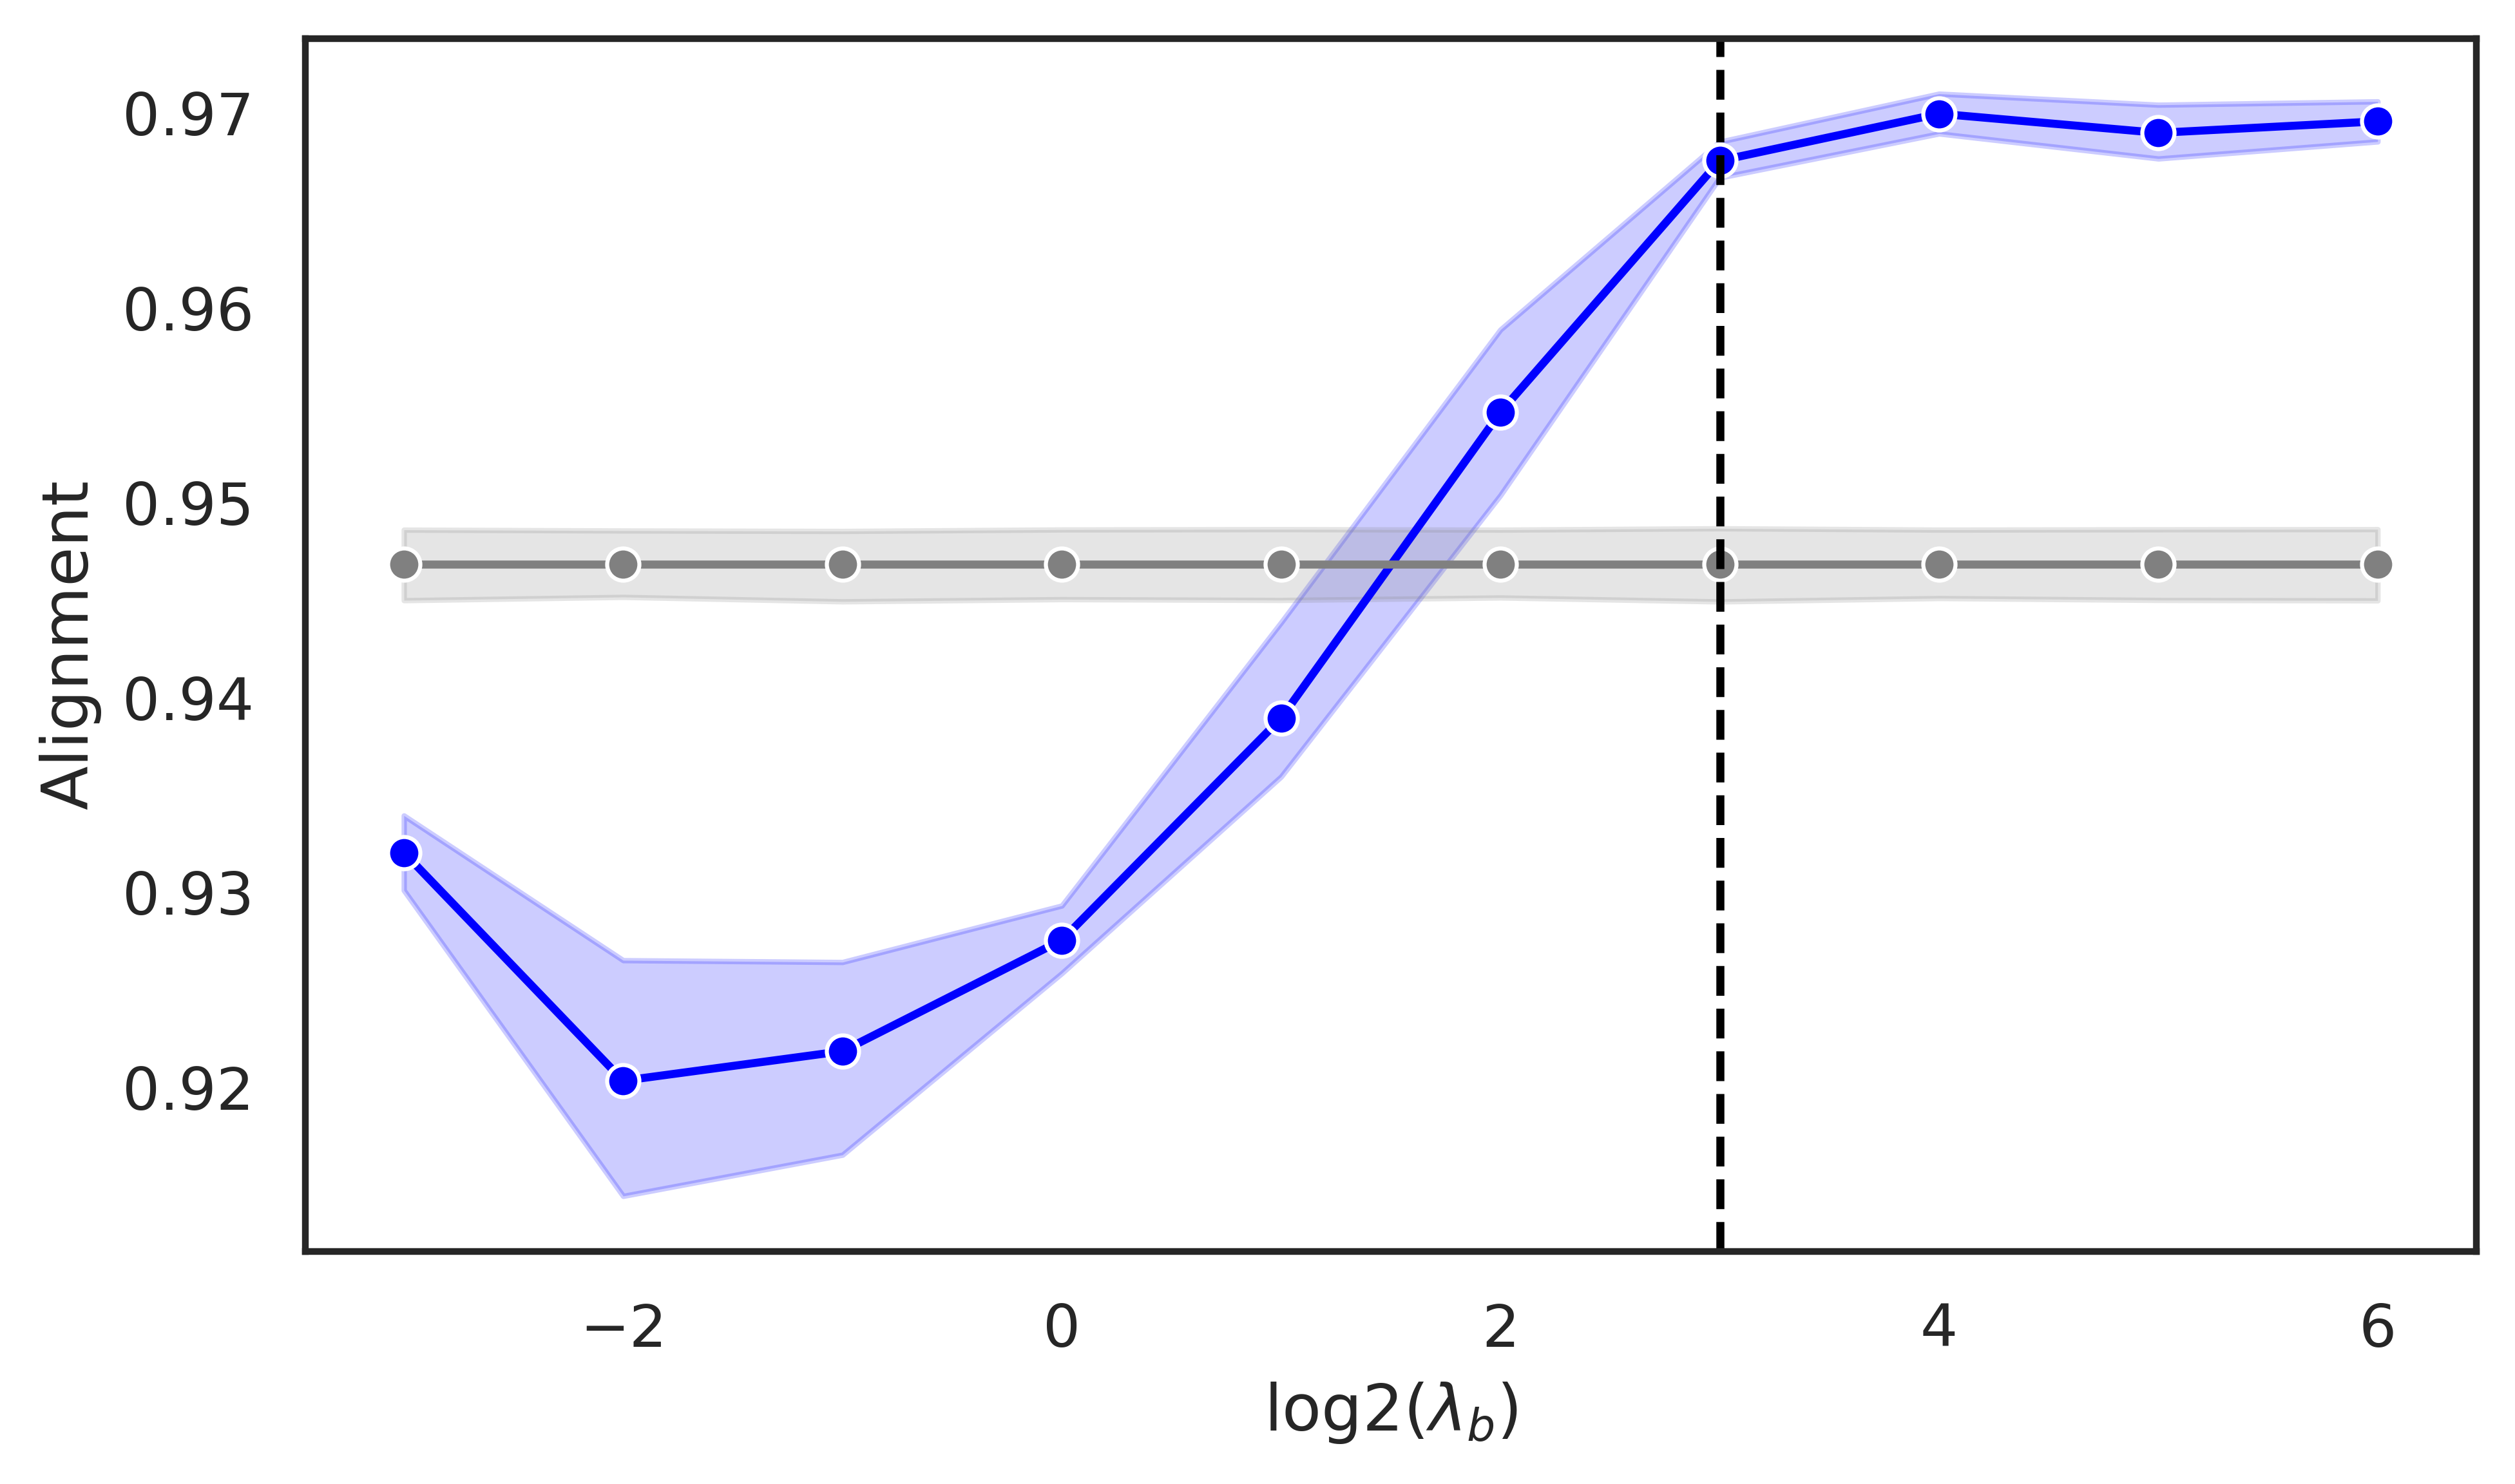

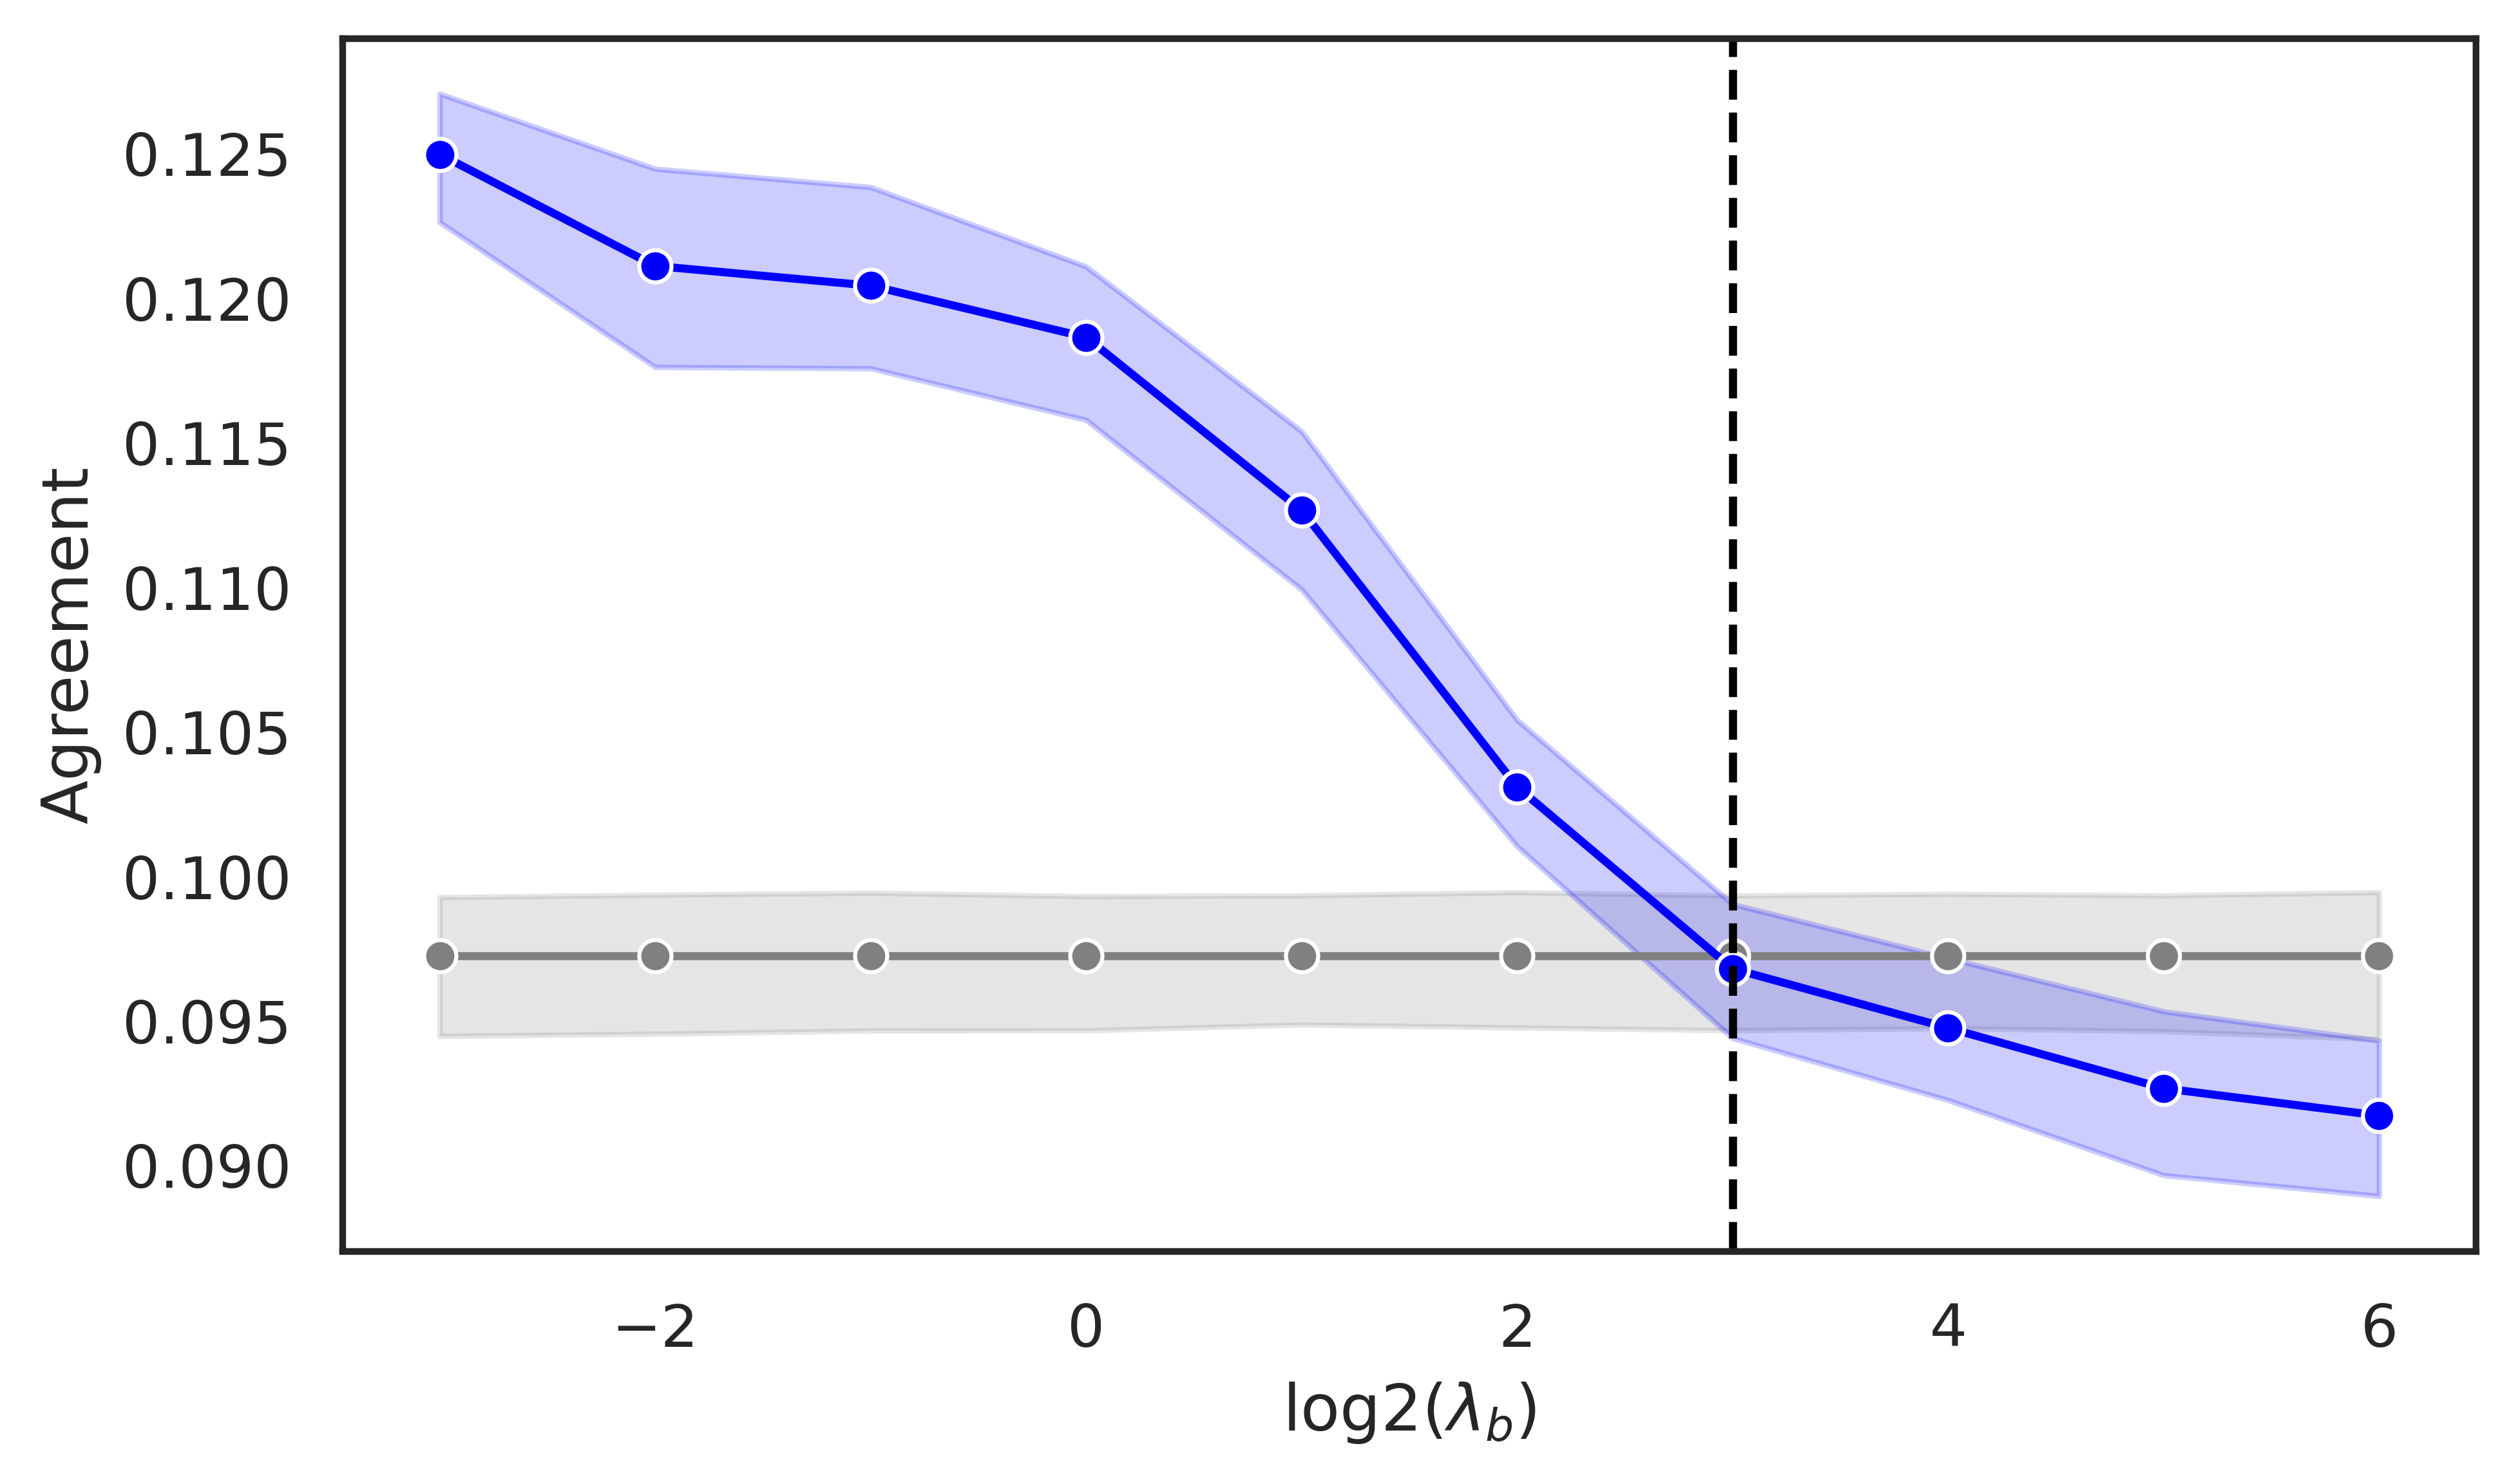

In [57]:
sns.set(style = 'white')
#sns.set(xtick.bottom=True,ytick.left=True,axes.spines.right=False,axes.spines.top=False)
plt.figure(dpi = 600, figsize=(10*2/3,4))
sns.lineplot(data = align_test, x = 'log2($\lambda_b$)', y = 'Alignment', 
             marker = 'o', color = 'blue')
sns.lineplot(data = liger_metr, x = 'log2($\lambda_b$)', y = 'Alignment', 
             marker = 'o', color = 'grey')
plt.axvline(3, c = 'black', linestyle = '--')
plt.tight_layout()
plt.savefig(fig_dir+'SF_2/alignment_benchmark_immune_conf_new.png', dpi = 600)
plt.figure(dpi = 600, figsize=(10*2/3,4))
sns.lineplot(data = liger_metr, x = 'log2($\lambda_b$)', y = 'Agreement', 
             marker = 'o', color = 'grey')
sns.lineplot(data = align_test, x = 'log2($\lambda_b$)', y = 'Agreement', 
             marker = 'o', color = 'blue')
plt.axvline(3, c = 'black', linestyle = '--')
plt.tight_layout()
plt.savefig(fig_dir+'SF_2/agreement_benchmark_immune_conf_new.png', dpi = 600)